In [1]:
import emcee
import numpy as np
import scipy
from astropy.io import fits
from astropy.table import Table
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.cosmology import Planck18 as cosmo
from functools import partial
import time

In [2]:
path_halo = '/sps/lsst/groups/clusters/cluster_comparison_project/after_matching/cosmoDC2_pywazp.DC2.tpz.T500k.pointEstimateMags/zband/proximity_matching/deltaz_0.03_matchradius_1.0mpc_pref_more_massive/cat1.fits'

path_amas = '/sps/lsst/groups/clusters/cluster_comparison_project/after_matching/cosmoDC2_pywazp.DC2.tpz.T500k.pointEstimateMags/zband/proximity_matching/deltaz_0.03_matchradius_1.0mpc_pref_more_massive/cat2.fits'

t = Table.read(path_amas)

def table(path):
    with fits.open(path) as hdul:
        table = Table(hdul[1].data)
    return table

t_halo = table(path_halo)
t_amas = table(path_amas)
t_amas_match = t_amas[t_amas["mt_cross"] !='']

M = []
for id in t_amas_match["mt_cross"]:
    ligne = t_halo[t_halo["halo_id"] == id]
    M.append(ligne["m200c"][0])
t_amas_match["M"] = M
t_amas_match = t_amas_match[t_amas_match["snr"]>6]

def tableau_coupure_n200(coupure):
    return t_amas_match[t_amas_match["n200"]>coupure]
def tableau_bin_n200(binn):
    a, b = binn
    return t_amas_match[(t_amas_match["n200"]>a) & (t_amas_match["n200"]<b)]

Mp, zp = 10**14.3, 0.5


In [3]:
def prior(params):
    A, B, C, D, E, F = params
    if -2<C<2 or -2<E<2 or -2<F<2:
        return True
    else:
        return False

#X est le catalogue
def _ln_L(params, X, a, b):
    A, B, C, D, E, F = params
    prior_check = prior(params)
    if not prior_check:
        return -np.inf
    pop, M, z = np.log(X["n200"]), X["M"], X["zp"]
    mean_alpha = A + B*np.log(M/Mp) + C*np.log((1+z)/(1+zp))
    sigma = D + E*np.log(M/Mp) + F*np.log((1+z)/(1+zp))
    sigma = np.clip(sigma, 1e-5, None)
    #print("sigma max/min :", max(sigma), min(sigma))
    #log-Vraissemblance
    erf = lambda x: scipy.special.erf((np.log(x)-mean_alpha)/(sigma*2**0.5))
    correction = lambda a, b: erf(b)-erf(a)
    ln_L = - sum(np.log(sigma*(2*np.pi)**0.5)) - sum(0.5*((pop-mean_alpha)/sigma)**2) - sum(0.5*correction(a, b))
    return ln_L

In [4]:
def MCMC(richesse_bin, redshift_bin, itt):
    a, b = richesse_bin
    c, d = redshift_bin
    X = t_amas_match[(t_amas_match["n200"]>a) & (t_amas_match["n200"]<b) & (t_amas_match["zp"]>c) & (t_amas_match["zp"]<d)]
    
    ndim, nwalkers = 6, 25
    ivar = 1. / np.random.rand(ndim)
    p0 = np.random.randn(nwalkers, ndim) # points de départ pour les walkers
    sampler = emcee.EnsembleSampler(nwalkers, ndim, _ln_L, args=[X, a, b])
    S = sampler.run_mcmc(p0, itt)
    sample = sampler.get_chain()
    
    list_A, list_B, list_C, list_D, list_E, list_F  = [], [], [], [], [], []
    for step in range(len(sample)):
        list_A.append(np.mean(sample[step, :, 0])) # récupération des paramètres
        list_B.append(np.mean(sample[step, :, 1]))
        list_C.append(np.mean(sample[step, :, 2]))
        list_D.append(np.mean(sample[step, :, 3]))
        list_E.append(np.mean(sample[step, :, 4]))
        list_F.append(np.mean(sample[step, :, 5]))    
    
    A = np.mean(list_A[len(list_A)//2:])
    B = np.mean(list_B[len(list_B)//2:])
    C = np.mean(list_C[len(list_C)//2:])
    D = np.mean(list_D[len(list_D)//2:])
    E = np.mean(list_E[len(list_E)//2:])
    F = np.mean(list_F[len(list_F)//2:])
    
    std_A = np.std(list_A[len(list_A)//2:])
    std_B = np.std(list_B[len(list_B)//2:])
    std_C = np.std(list_C[len(list_C)//2:])
    std_D = np.std(list_D[len(list_D)//2:])
    std_E = np.std(list_E[len(list_E)//2:])
    std_F = np.std(list_F[len(list_F)//2:])

    res = {}
    res['mean'] = (A, B, C, D, E, F)
    res['std'] = (std_A, std_B, std_C, std_D, std_E, std_F)
    res['list'] = (list_A, list_B, list_C, list_D, list_E, list_F)

    return res

In [55]:
dl = 10
N = 10
centre_bin_redshift = np.array([0.3, 0.55, 0.85, 1.25])
list_bin_redshift = np.array([(0.2, 0.4), (0.4, 0.7), (0.7, 1), (1, 1.5)])
centre_bin_richesse = np.linspace(20+dl, 80-dl, N)
list_bin_richesse = []
for i in range(N):
    list_bin_richesse.append((centre_bin_richesse[i]-dl, centre_bin_richesse[i]+dl))

In [64]:
mat_mean_A = np.zeros((len(centre_bin_redshift), N))
mat_std_A = np.zeros((len(centre_bin_redshift), N))

mat_mean_B = np.zeros((len(centre_bin_redshift), N))
mat_std_B = np.zeros((len(centre_bin_redshift), N))

mat_mean_C = np.zeros((len(centre_bin_redshift), N))
mat_std_C = np.zeros((len(centre_bin_redshift), N))

mat_mean_D = np.zeros((len(centre_bin_redshift), N))
mat_std_D = np.zeros((len(centre_bin_redshift), N))

mat_mean_E = np.zeros((len(centre_bin_redshift), N))
mat_std_E = np.zeros((len(centre_bin_redshift), N))

mat_mean_F = np.zeros((len(centre_bin_redshift), N))
mat_std_F = np.zeros((len(centre_bin_redshift), N))

In [66]:
centre_bin_redshift

array([0.3 , 0.55, 0.85, 1.25])

In [91]:
T = time.time()
for bin_z in range(len(centre_bin_redshift)):
    for bin_n200 in range(len(centre_bin_richesse)):       
        resultat = MCMC(richesse_bin = list_bin_richesse[bin_n200], 
                        redshift_bin = list_bin_redshift[bin_z], 
                        itt = 2000)
        A, B, C, D, E, F = resultat['mean']
        std_A, std_B, std_C, std_D, std_E, std_F = resultat['std']
        
        mat_mean_A[bin_z, bin_n200] = A
        mat_mean_B[bin_z, bin_n200] = B
        mat_mean_C[bin_z, bin_n200] = C
        mat_mean_D[bin_z, bin_n200] = D
        mat_mean_E[bin_z, bin_n200] = E
        mat_mean_F[bin_z, bin_n200] = F
        
        mat_std_A[bin_z, bin_n200] = std_A
        mat_std_B[bin_z, bin_n200] = std_B
        mat_std_C[bin_z, bin_n200] = std_C
        mat_std_D[bin_z, bin_n200] = std_D
        mat_std_E[bin_z, bin_n200] = std_E
        mat_std_F[bin_z, bin_n200] = std_F
        print(bin_z, bin_n200)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9


In [92]:
print(mat_mean_A)
print(mat_std_A)

[[3.46915746 3.5355219  3.58739489 3.69334157 3.76652239 3.94636189
  3.99841888 4.09808408 4.17237117 4.22820117]
 [3.40448324 3.52750098 3.61023223 3.72268853 3.81939527 3.92511097
  4.02431903 4.07122347 4.12864046 4.17455183]
 [3.31720992 3.48169388 3.59581627 3.68151295 3.84253841 3.86735013
  4.01394101 4.14492642 4.19299633 4.3141569 ]
 [3.5200806  3.6687373  3.81839944 3.81972272 3.99448011 3.97696292
  3.89875608 4.0783949  3.96149285 4.18247941]]
[[0.00939976 0.00897418 0.00834524 0.01121106 0.01131198 0.01277675
  0.01260655 0.0131836  0.01441044 0.01308119]
 [0.00360069 0.00323041 0.00278218 0.00309256 0.00313725 0.00313058
  0.00289714 0.00268204 0.00225744 0.00364167]
 [0.00548914 0.00696237 0.0081932  0.00753141 0.00967515 0.00956777
  0.00913776 0.01104021 0.00987242 0.01069964]
 [0.01163608 0.01324368 0.01354881 0.01613342 0.02356503 0.03296373
  0.03379358 0.03406286 0.03237333 0.05062832]]


In [93]:
for i in range(len(mat_mean_A)):
    for j in range(len(mat_mean_A[0])):
        if abs(mat_std_A[i, j]) > 10 or abs(mat_mean_A[i, j] - np.mean(mat_mean_A)) > 5 :
            mat_std_A[i, j], mat_mean_A[i, j] = 0, 0
        if abs(mat_std_B[i, j]) > 10 or abs(mat_mean_B[i, j] - np.mean(mat_mean_B)) > 5 :
            mat_std_B[i, j], mat_mean_B[i, j] = 0, 0
        if abs(mat_std_C[i, j]) > 10 or abs(mat_mean_C[i, j] - np.mean(mat_mean_C)) > 5 :
            mat_std_C[i, j], mat_mean_C[i, j] = 0, 0
        if abs(mat_std_D[i, j]) > 10 or abs(mat_mean_D[i, j] - np.mean(mat_mean_D)) > 5 :
            mat_std_D[i, j], mat_mean_D[i, j] = 0, 0
        if abs(mat_std_E[i, j]) > 10 or abs(mat_mean_E[i, j] - np.mean(mat_mean_E)) > 5 :
            mat_std_E[i, j], mat_mean_E[i, j] = 0, 0
        if abs(mat_std_F[i, j]) > 10 or abs(mat_mean_F[i, j] - np.mean(mat_mean_F)) > 5 :
            mat_std_F[i, j], mat_mean_F[i, j] = 0, 0
        

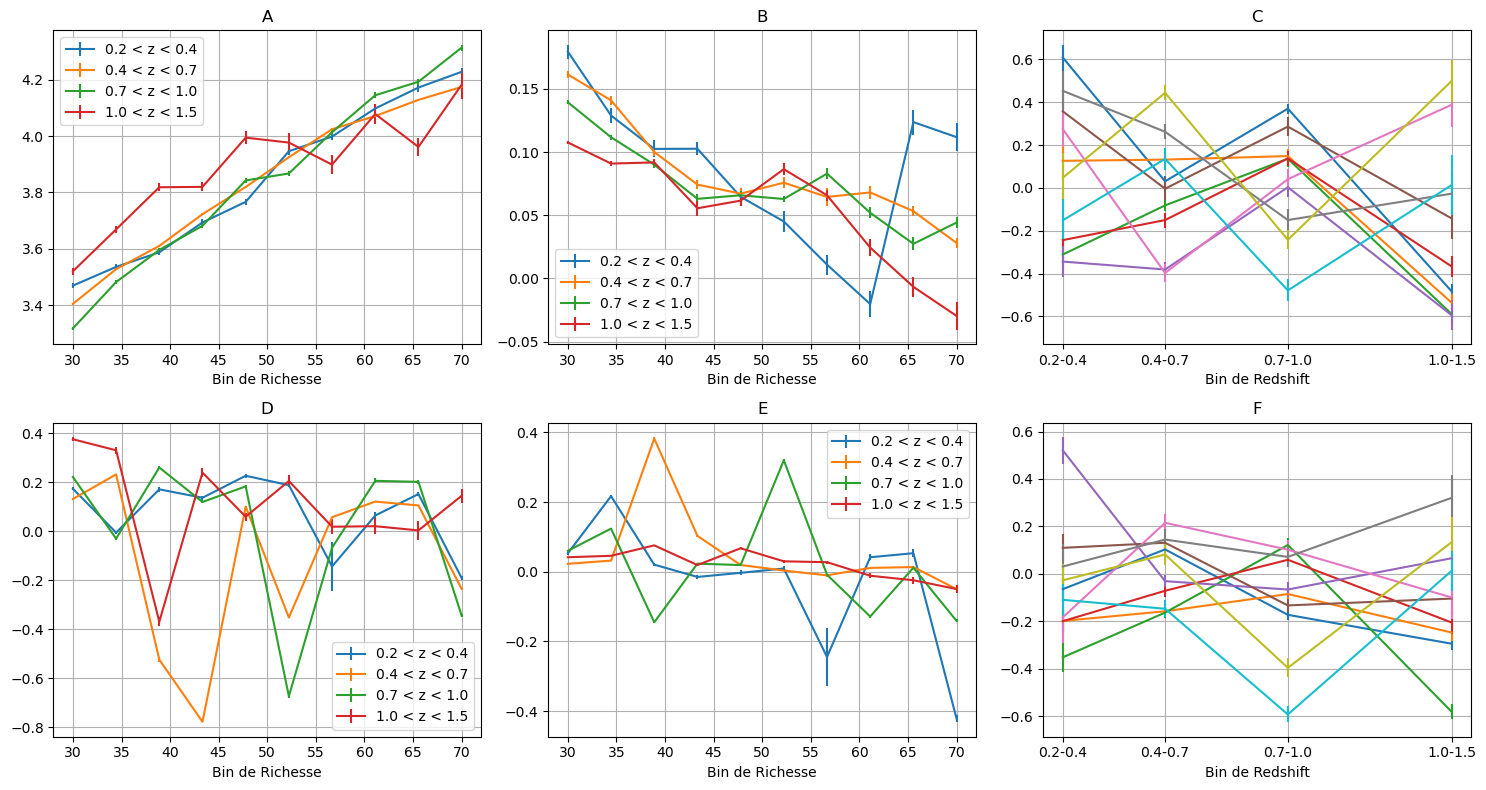

In [100]:
#plots pour bin_z de A(bin_richesse)
"""plt.errorbar([20, 40, 60, 80], mat_mean_A[0], yerr = mat_std_A[0], label = "0.2 < z < 0.4")
plt.errorbar([20, 40, 60, 80], mat_mean_A[1], yerr = mat_std_A[1], label = "0.4 < z < 0.8")
plt.errorbar([20, 40, 60, 80], mat_mean_A[2], yerr = mat_std_A[2], label = "0.8 < z < 1.5")
plt.xlabel('Bin de Richesse')
plt.ylabel('')
plt.legend()
plt.grid()"""


bin_centers = centre_bin_richesse
#bin_labels = [f"{i[0]}-{i[1]}" for i in list_bin_richesse]
fig, ax = plt.subplots(2, 3, figsize=(15, 8), sharex=False, sharey=False)
x = bin_centers

bin_centers_z = centre_bin_redshift
bin_labels_z = [f"{i[0]}-{i[1]}" for i in list_bin_redshift]
x_z = bin_centers_z

for i in range(len(list_bin_redshift)):
    ax[0, 0].errorbar(x, mat_mean_A[i], yerr = mat_std_A[i], label = str(list_bin_redshift[i][0])+" < z < "+str(list_bin_redshift[i][1]))
    ax[0, 1].errorbar(x, mat_mean_B[i], yerr = mat_std_B[i], label = str(list_bin_redshift[i][0])+" < z < "+str(list_bin_redshift[i][1]))
    ax[1, 0].errorbar(x, mat_mean_D[i], yerr = mat_std_D[i], label = str(list_bin_redshift[i][0])+" < z < "+str(list_bin_redshift[i][1]))
    ax[1, 1].errorbar(x, mat_mean_E[i], yerr = mat_std_E[i], label = str(list_bin_redshift[i][0])+" < z < "+str(list_bin_redshift[i][1]))

for i in range(len(list_bin_richesse)):
    ax[0, 2].errorbar(x_z, mat_mean_C[:,i], yerr = mat_std_C[:,i], label = str(list_bin_richesse[i][0])+" < \lambda < "+str(list_bin_richesse[i][1]))
    ax[1, 2].errorbar(x_z, mat_mean_F[:,i], yerr = mat_std_F[:,i], label = str(list_bin_richesse[i][0])+" < \lambda < "+str(list_bin_richesse[i][1]))

ax[0, 0].set_title('A')
ax[0, 0].set_xlabel('Bin de Richesse')
ax[0, 0].legend()
ax[0, 0].grid()
# Appliquer les labels personnalisés
#ax[0, 0].set_xticks(bin_centers)
#ax[0, 0].set_xticklabels(bin_labels)

ax[0, 1].set_title('B')
ax[0, 1].set_xlabel('Bin de Richesse')
ax[0, 1].legend()
ax[0, 1].grid()

ax[1, 0].set_title('D')
ax[1, 0].set_xlabel('Bin de Richesse')
ax[1, 0].legend()
ax[1, 0].grid()

ax[1, 1].set_title('E')
ax[1, 1].set_xlabel('Bin de Richesse')
ax[1, 1].legend()
ax[1, 1].grid()


ax[0, 2].set_title('C')
ax[0, 2].set_xlabel('Bin de Redshift')
#ax[0, 2].legend()
ax[0, 2].grid()
# Appliquer les labels personnalisés
ax[0, 2].set_xticks(bin_centers_z)
ax[0, 2].set_xticklabels(bin_labels_z)

ax[1, 2].set_title('F')
ax[1, 2].set_xlabel('Bin de Redshift')
#ax[1, 2].legend()
ax[1, 2].grid()
# Appliquer les labels personnalisés
ax[1, 2].set_xticks(bin_centers_z)
ax[1, 2].set_xticklabels(bin_labels_z)






plt.tight_layout()
plt.show()

In [95]:
print(list_bin_richesse[0], list_bin_redshift[0])


(np.float64(20.0), np.float64(40.0)) [0.2 0.4]


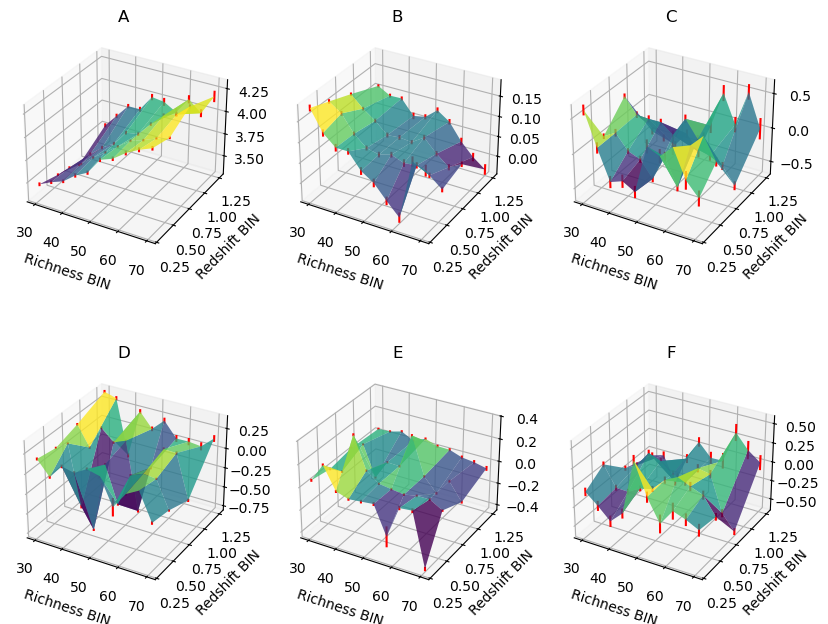

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Données
x = centre_bin_richesse
y = centre_bin_redshift
X, Y = np.meshgrid(x, y)

# Affichage 3D
fig = plt.figure(figsize=(10, 8))
ax_A = fig.add_subplot(231, projection='3d')
ax_B = fig.add_subplot(232, projection='3d')
ax_C = fig.add_subplot(233, projection='3d')
ax_D = fig.add_subplot(234, projection='3d')
ax_E = fig.add_subplot(235, projection='3d')
ax_F = fig.add_subplot(236, projection='3d')

ax_A.plot_surface(X, Y, mat_mean_A, cmap='viridis', alpha=0.8)
ax_A.set_title('A')
ax_A.set_xlabel('Richness BIN')
ax_A.set_ylabel('Redshift BIN')
for i in range(mat_mean_A.shape[0]):
    for j in range(mat_mean_A.shape[1]):
        z = mat_mean_A[i, j]
        err = mat_std_A[i, j]
        ax_A.plot(
            [X[i, j], X[i, j]],
            [Y[i, j], Y[i, j]],
            [z - err, z + err],
            color='red', linewidth=1.5)

ax_B.plot_surface(X, Y, mat_mean_B, cmap='viridis', alpha=0.8)
ax_B.set_title('B')
ax_B.set_xlabel('Richness BIN')
ax_B.set_ylabel('Redshift BIN')
for i in range(mat_mean_B.shape[0]):
    for j in range(mat_mean_B.shape[1]):
        z = mat_mean_B[i, j]
        err = mat_std_B[i, j]
        ax_B.plot(
            [X[i, j], X[i, j]],
            [Y[i, j], Y[i, j]],
            [z - err, z + err],
            color='red', linewidth=1.5)

ax_C.plot_surface(X, Y, mat_mean_C, cmap='viridis', alpha=0.8)
ax_C.set_title('C')
ax_C.set_xlabel('Richness BIN')
ax_C.set_ylabel('Redshift BIN')
for i in range(mat_mean_C.shape[0]):
    for j in range(mat_mean_C.shape[1]):
        z = mat_mean_C[i, j]
        err = mat_std_C[i, j]
        ax_C.plot(
            [X[i, j], X[i, j]],
            [Y[i, j], Y[i, j]],
            [z - err, z + err],
            color='red', linewidth=1.5)

ax_D.plot_surface(X, Y, mat_mean_D, cmap='viridis', alpha=0.8)
ax_D.set_title('D')
ax_D.set_xlabel('Richness BIN')
ax_D.set_ylabel('Redshift BIN')
for i in range(mat_mean_D.shape[0]):
    for j in range(mat_mean_D.shape[1]):
        z = mat_mean_D[i, j]
        err = mat_std_D[i, j]
        ax_D.plot(
            [X[i, j], X[i, j]],
            [Y[i, j], Y[i, j]],
            [z - err, z + err],
            color='red', linewidth=1.5)

ax_E.plot_surface(X, Y, mat_mean_E, cmap='viridis', alpha=0.8)
ax_E.set_title('E')
ax_E.set_xlabel('Richness BIN')
ax_E.set_ylabel('Redshift BIN')
for i in range(mat_mean_E.shape[0]):
    for j in range(mat_mean_E.shape[1]):
        z = mat_mean_E[i, j]
        err = mat_std_E[i, j]
        ax_E.plot(
            [X[i, j], X[i, j]],
            [Y[i, j], Y[i, j]],
            [z - err, z + err],
            color='red', linewidth=1.5)

ax_F.plot_surface(X, Y, mat_mean_F, cmap='viridis', alpha=0.8)
ax_F.set_title('F')
ax_F.set_xlabel('Richness BIN')
ax_F.set_ylabel('Redshift BIN')
for i in range(mat_mean_F.shape[0]):
    for j in range(mat_mean_F.shape[1]):
        z = mat_mean_F[i, j]
        err = mat_std_F[i, j]
        ax_F.plot(
            [X[i, j], X[i, j]],
            [Y[i, j], Y[i, j]],
            [z - err, z + err],
            color='red', linewidth=1.5)


plt.show()

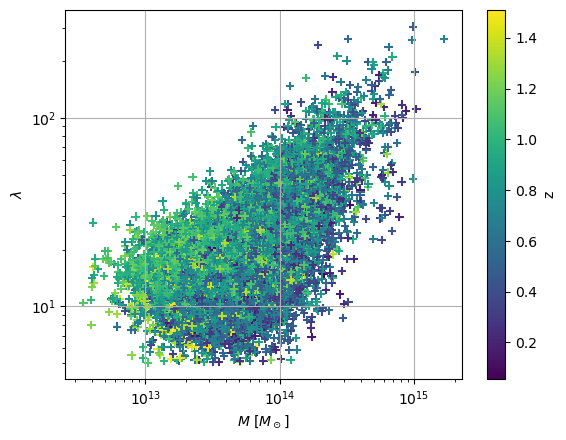

In [113]:
plt.scatter(t_amas_match["M"], t_amas_match["n200"], c=t_amas_match['zp'], cmap='viridis', marker = '+')
plt.yscale("log")
plt.xscale("log")
plt.colorbar(label='z')
plt.ylabel(r'$\lambda$')
plt.xlabel(r'$M\ [M_\odot]$')
plt.grid()

  id          ra         ...    mt_cross           M         
----- ------------------ ... ------------- ------------------
28076  49.63867447643211 ...   13600185373  48262730754884.51
18987 49.731391597997565 ...  148900185401  71026349843470.42
14691   49.7524961319947 ...  915400175272 45883818999346.484
10169   49.7684383025463 ... 2089000185253  49238760064360.56
11753  49.79095468759522 ...  907600185293  66679763070918.31
13519 49.821474108647244 ...  390100185259  43088468977577.47
15463 49.836517775261186 ...  482400175293  70747859872811.27
 5455   49.8644511799957 ... 2048700175293  34879406726129.58
12768  49.87007581833548 ...  152400175203  9536463471053.521
27230 49.888004330253374 ...  391800185241  38421744567887.33
  ...                ... ...           ...                ...
 4336  73.87689882180888 ...  476300183286 424794288624135.25
  986  73.87972947281044 ...  132200183411 195073250999166.22
25181  73.88927626064174 ... 1314100183286  578572360089600.0
 6001  7

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

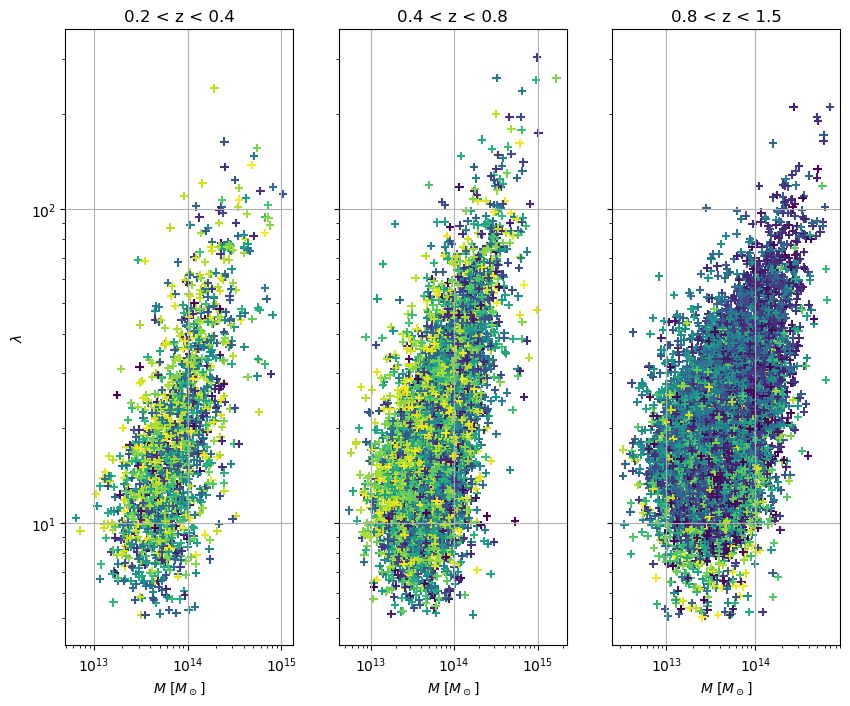

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(10, 8), sharex=False, sharey=True)

m = np.logspace(13, 15, 10)
l = np.logspace(0, np.log10(200), 10)
z1, z2, z3 = 0.3, 0.6, 1
model = lambda m, z, A, B, C: A+B*np.log(M/Mp)+C*np.log((1+z)/(1+zp))
ax[0].plot(m, l, model(m, l, ))


tableau_bin = t_amas_match[(t_amas_match['zp']>0.2)&(t_amas_match['zp']<0.4)]
print(t_amas_match)
ax[0].set_title('0.2 < z < 0.4')
ax[0].scatter(tableau_bin["M"], tableau_bin["n200"], c=tableau_bin['zp'], cmap='viridis', marker = '+')
ax[0].set_yscale("log")
ax[0].set_xscale("log")
ax[0].set_ylabel(r'$\lambda$')
ax[0].set_xlabel(r'$M\ [M_\odot]$')
ax[0].grid()


tableau_bin = t_amas_match[(t_amas_match['zp']>0.4)&(t_amas_match['zp']<0.8)]
ax[1].set_title('0.4 < z < 0.8')
ax[1].scatter(tableau_bin["M"], tableau_bin["n200"], c=tableau_bin['zp'], cmap='viridis', marker = '+')
ax[1].set_yscale("log")
ax[1].set_xscale("log")
ax[1].set_xlabel(r'$M\ [M_\odot]$')
ax[1].grid()

tableau_bin = t_amas_match[(t_amas_match['zp']>0.8)&(t_amas_match['zp']<1.5)]
ax[2].set_title('0.8 < z < 1.5')
ax[2].scatter(tableau_bin["M"], tableau_bin["n200"], c=tableau_bin['zp'], cmap='viridis', marker = '+')
ax[2].set_yscale("log")
ax[2].set_xscale("log")
ax[2].set_xlabel(r'$M\ [M_\odot]$')
ax[2].grid()

plt.colorbar(label='z')
plt.show()

In [21]:
ABCDEF1 =  MCMC(richesse_bin = (0, 1000), redshift_bin = (0.2, 0.4), itt = 100)

NameError: name 'MCMC' is not defined